Makemore pt3
Use an RNN to model a character level language model.
[Video](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4)

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import IPython

In [17]:
# Mac OS GPU acceleration or CPU
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [18]:
# Load names from file
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [19]:
# Create vocab of characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print('stoi', stoi)
print('itos', itos)
vocab_size = len(itos)


stoi {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [20]:
# Create dataset
block_size = 4 # char context length

def build_dataset(words):
    X, Y = [], [] # X = Data, Y = Target
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # next char to be predicted and added to context
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

train_n = int(len(words) * 0.8)
dev_n = int(len(words) * 0.1)
test_n = len(words) - train_n - dev_n
random.shuffle(words)
train_words = words[:train_n]
dev_words = words[train_n:train_n+dev_n]
test_words = words[train_n+dev_n:]

train_X, train_Y = build_dataset(train_words)
dev_X, dev_Y = build_dataset(dev_words)
test_X, test_Y = build_dataset(test_words)

In [21]:
# Define the MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g, device=device) * (5/3) / ((block_size * n_embd)**0.5) # Optimising the initialisations for the activation function, yields 5% better loss.
W1 = torch.randn((block_size * n_embd,n_hidden), generator=g, device=device) * 0.01
# b1 = torch.randn(n_hidden, generator=g, device=device) # Bias is not needed for batch norm, it is redunant because the addition
W2 = torch.randn((n_hidden,vocab_size), generator=g, device=device)  * 0.01 # We squash the weights to have better initialisation loss. network ends up training for longer in the "hard" part of the loss curve so we get a better result. 5% better loss.
b2 = torch.randn(vocab_size, generator=g, device=device) * 0

# Batch norm gain and shift
bngain = torch.ones((1, n_hidden), device=device)
bnbias = torch.zeros((1, n_hidden), device=device)
bnmean_running = torch.zeros((1, n_hidden), device=device)
bnstd_running = torch.ones((1, n_hidden), device=device)

# Sum number of parameters
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


14097


  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000 loss: 3.2895


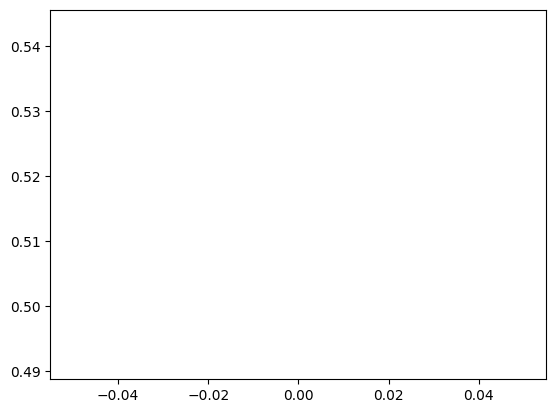

In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps)):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass

    # embedding layer
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    # Linear layer
    hpreact = embcat @ W1 # no + b1 because batch norm makes it redundant. bias term is a single number.
    
    # Batch Norm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch norm
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

# Plot
plt.plot(lossi)

In [23]:
# Using batch norm during inference of single examples requires you to compute the mean and std of the training set and add that in as a hardcoded parameter
# with torch.no_grad():
#     emb = C[train_X]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     bnmean = hpreact.mean(0, keepdim=True)
#     print(bnmean)
#     bnstd = hpreact.std(0, keepdim=True)
#     print(bnstd)

# We don't need to do this if we use bnmean_running and bnstd_running to compute the mean and std of the training set

In [24]:
# Evaluation
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (train_X, train_Y),
        'dev': (dev_X, dev_Y),
        'test': (test_X, test_Y),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch norm

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')
split_loss('train')
split_loss('dev')
split_loss('test')

NameError: name 'b1' is not defined

Test Loss to beat

With BatchNorm:
train loss: 2.0184
dev loss: 2.0706
test loss: 2.0592

In [ ]:
# Sampling from model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

NameError: name 'b1' is not defined

In [ ]:
# Expected loss at initialisation assuming equal distribution
loss = - torch.log(torch.tensor(1/27)) # probability of each character is 1/27 naively and this is how the loss should be calculated.
print(loss)
# Random initialisation of the network is leading to high loss. You can reduce the values of the weights of network at initialisation so the softmaxed outputs are less extreme.

tensor(3.2958)


# PyTorch-like version of the above training loop with visual histograms for telemetry and debugging

In [25]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
#   layers[-1].gamma *= 0.1 # for batchnorm "weight"
  layers[-1].weight *= 0.1 # linear "weight"
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47497


In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
  Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2826


layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 2.91%
layer 3 (      Tanh): mean +0.04, std 0.48, saturated: 0.09%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean -0.01, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.31, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

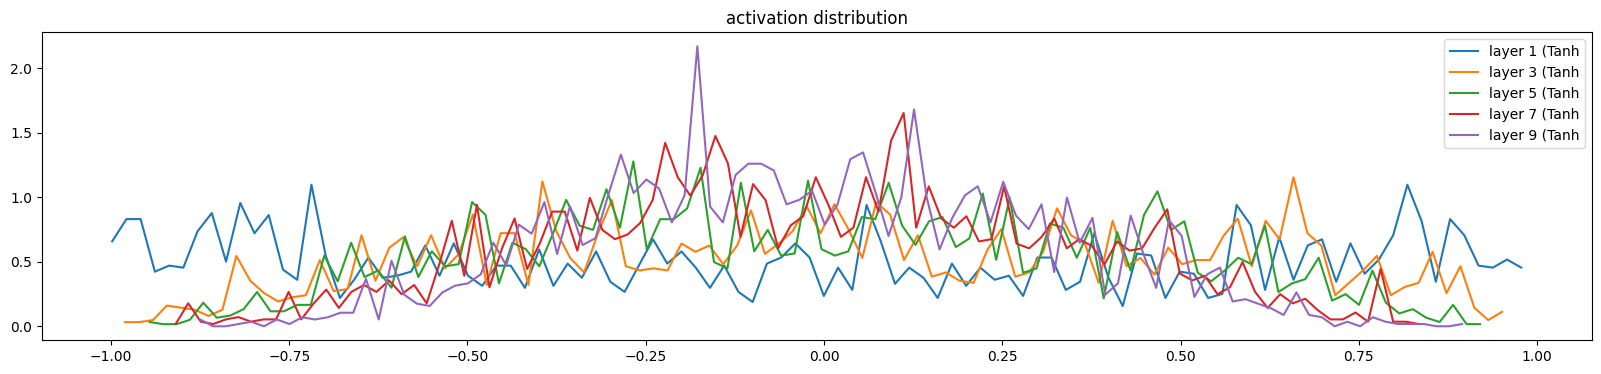

In [31]:
# visualize histograms - activations
# Should be not too extreme on the tails and same across the layers
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000005, std 1.584475e-04
layer 3 (      Tanh): mean +0.000000, std 2.012290e-04
layer 5 (      Tanh): mean -0.000011, std 2.512124e-04
layer 7 (      Tanh): mean -0.000004, std 2.760076e-04
layer 9 (      Tanh): mean -0.000017, std 2.995851e-04


Text(0.5, 1.0, 'gradient distribution')

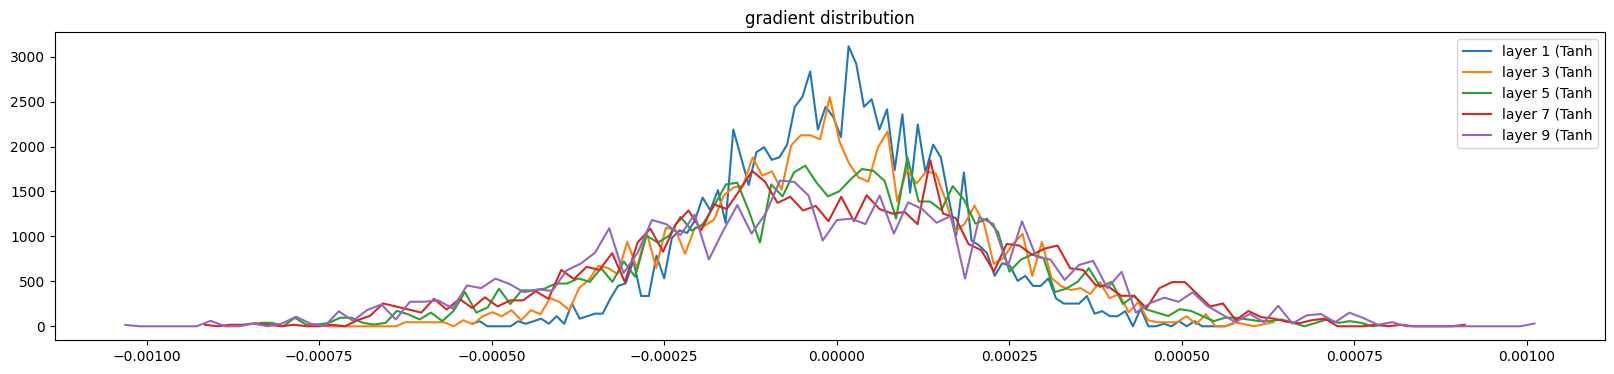

In [33]:
# visualize histograms - gradients over layer
# all layers should roughly the same gradient.
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000029 | std 5.526809e-04 | grad:data ratio 5.522807e-04
weight  (40, 100) | mean -0.000006 | std 7.399040e-04 | grad:data ratio 4.605481e-03
weight (100, 100) | mean +0.000004 | std 7.224525e-04 | grad:data ratio 7.186567e-03
weight (100, 100) | mean -0.000020 | std 7.857583e-04 | grad:data ratio 7.907370e-03
weight (100, 100) | mean -0.000001 | std 7.957935e-04 | grad:data ratio 7.992919e-03
weight (100, 100) | mean +0.000011 | std 6.888199e-04 | grad:data ratio 6.835237e-03
weight  (100, 27) | mean +0.000000 | std 1.240582e-02 | grad:data ratio 1.226069e+00


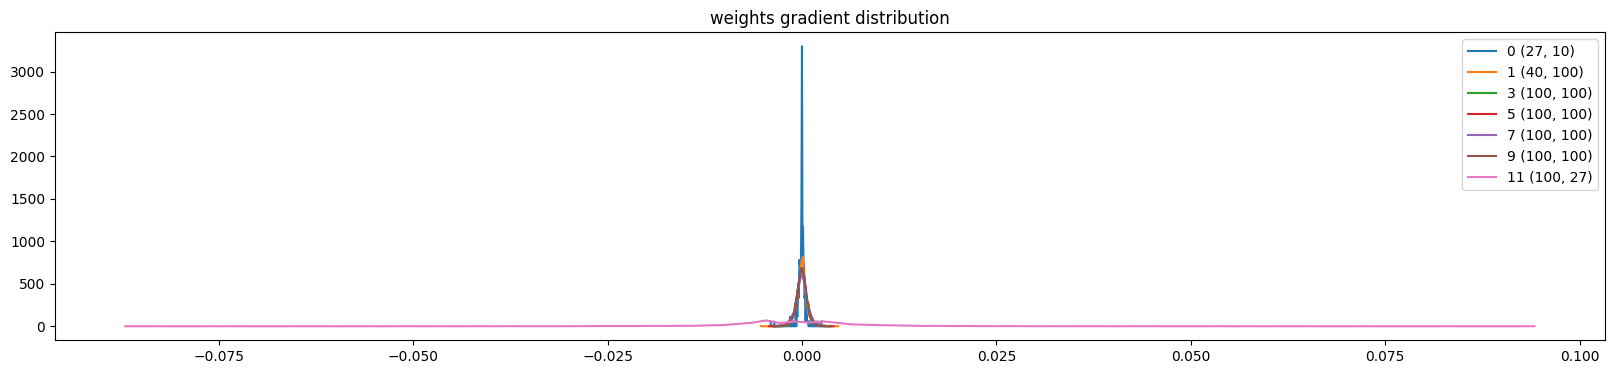

In [34]:
# visualize histograms - weights over parameters

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

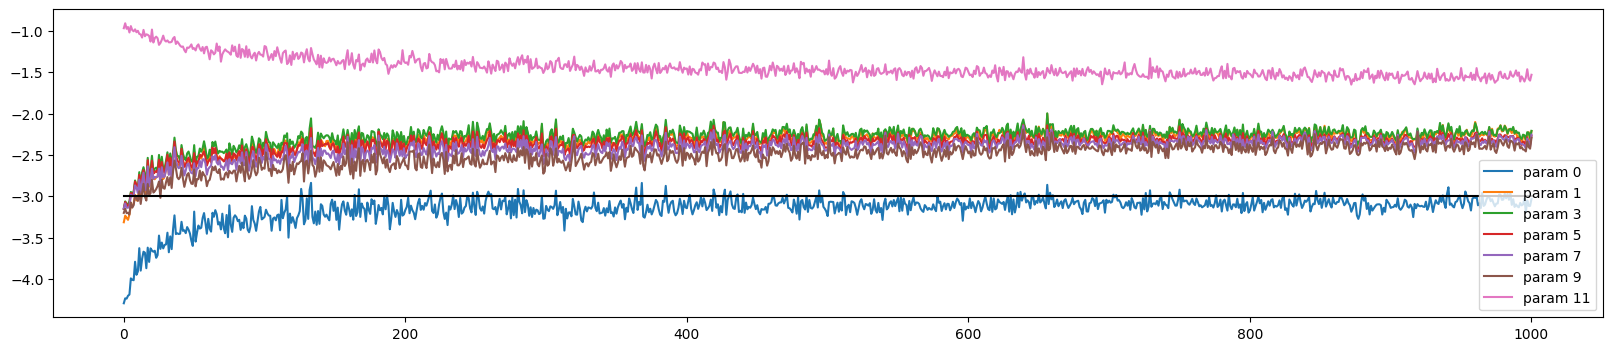

In [37]:
# Update ratio for each the weights
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)